# Code & Logic for Determining Account Metadata
### This file was created by making extensive use of `table_view_exploration_feature_engineering.ipynb` [witheld for GitHub]

Consider the following hypothesis:

---
> $H_1$: It is possible to predict (with some metric) if an account will be closed within the next 30-days using at minimum the following feature set:
>> {
    prior 30-transactions,
    is joint account?,
    age of account owner
}
---



### STEP 3: (logical breakdown of hypothesis exploration)
> When considering $H_1$ or $H_0$, how do we determine which **features** are amenable to our churn analysis?

For the aforementioned hypothesis:
This Jupyter Notebook is concerned with determining important features, solely, where additional separate files are to follow for subsequent steps.

* While our lookback period for **closed/open acounts** is **1/1/2022 - 8/1/2022** when we examine **metadata** associated with these accounts (but not account transactions) this examination period will consist of **9/1/2021 - 8/1/2022**.
    - 9/1/2022 has been chosen as a start date as it represents 90-days prior
    - 8/1/2022 has been chosen as an end date as it coincides with the account closure/opening end constraint
* For our features below we will not present data collected on closed accounts for the 30-days immediately prior to an accounts closure.
    - this prevents us from creating a model which uses future data.


#### IMPORTANT NOTE: Exploration carried out via BELLCO_PROD_DNA.OSIBANK, Bellco Credit Union's institutional data.

# FEATURE ENGINEERING
## Feature Engineering Idea List
Given the constraints of the underlying database/data collection integrity and also time not all of these ideas could be implemented and/or explored.  However, many ideas have been implemented and are summarized immediately below under **FEATURE SUMMARY**.
* **ACCOUNT INFORMATION**
    - account age
    - metadata about the **account owner**: demographics
        * income
        * zipcode
        * marital status (0/1)
        * DOB / age of account owner (DOB presented & model infers the respective account owner age)
        * total number of accounts (`acct` table lists primary account holder, so we can determine if they have any other accounts)
    - branch number current vs historical (BRANCHORGNBR vs ORGBRANCHNBR)
        * delta (create another feature, time permitting)
    - joint vs single ownership column (own cd column)
    - account lockouts/notes/warnings (check closed status code/make null or binary)
    - account changes / maint.
        * NSF (non-sufficient funds) fees assessed
* **TRANSACTION INFORMATION**
    * account balance info:
        - examine account transactions to determine if direct deposit/recurring transactions occur/stop
            * e.g. $1,500 every 2-weeks
        - recent balance dollar amount
    * account activity
        - unusual activity
        - type/source of transactions prior to account closure (OB vs branch, etc.)
        - loan paid off / sent elsewhere from indirect lending channel
            - indirect lending: car dealership refers someone to the financial institution for a car loan & is approved this way
        - rolling average number of transactions per day/week/etc.
            * the delta/change in average transactions may be illustrative of unusual activity

## FEATURE SUMMARY
* `trxn_acct` - binary {Y:1, N:0} - is the account in question a type capable of processing transaction? E.g. checking or savings accounts, etc.
* `retirement_acct` - binary {Y:1, N:0} - is the account in question a retirement account?
* `stmnt_acct` - binary {Y:1, N:0} - does the account in question have associated statements generated?
* `acct_valid` - binary {Y:1, N:0} - Was the account in question ever validated? 
* `num_acct_roles` - counting number/continuous {1:16} - the number of roles related to number of people w/ account access, including mbrs, but also employees or other
* `days_active` - continuous {days} - how long has it been since the account was opened? 
* `nsf_fees` - binary {Y:1, N:0} - was there at least 1 non-sufficient funds fee assessed during the lookback period?
* `uncollected_funds` - binary {Y:1, N:0} - were there uncollected funds under a given account during the lookback period?
* `atm_withdr` - binary {Y:1, N:0} - were there ATM withdrawals for a given account during the lookback period?
* `past_due` - binary {Y:1, N:0} - was the account past due for payment(s) during the lookback period?
* `AVG_ACCT_BAL` - continuous - This feature provides us with the account balance throughout the lookback period for each respective account located and the median for any missing accounts. 
* `acctlockoutflag` - binary {Y:1, N:0} - did an account have at least 1 active lockout flag during the lookback period?
* `acct_type` - categorical - 12 levels representing a mid-level category the account type falls into (checking, savings, mortgage loan, etc.)
* `own_single` - binary {Y:1, N:0} - if 1 then this account is solely owned, otherwise the account has joint ownership
* `acct_own_age` - continuous {2:108 years old} - derived from reported birthdate, which appears conspicuously missing for a fraction of the population.  The median age has been used to determine these missing values.
* `own_valid` - binary {1:Yes, 0:No} - Did the account owner pass Bellco's validation protocol?
* `credit_score` - continuous {300-850}/categorical - The primary account owner's average credit score for the lookback period 1/1/2022 - 8/1/2022
* `zipcode` - categorical - US exclusive zipcodes 
* `num_trxn` - counting number/continous - how many transactions were there for an associated account during the lookback period?
* `rtxn_source_mode` - counting/continuous - the most common category of transaction per account
* `trxn_issues` - binary {Y:1, N:0} - this feature indicates if there were any problems associated with account transactions, namely cancelled, reversed or rejected transactions.


### Features Unavilable Due to Underlying Data Collection Integrity
An attempt was made to utilize the following which are generally collected by convention for financial institution records:
* education level
* marital status
* income level
* number of dependents
* primary account owner's occupation
* does the primary account owner rent or own?
* NAICS SIC codes (Service Industry Code) related to the account and the account owner
* account source funds

In [1]:
import numpy as np
import pandas as pd
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import (
 col, lit, sum as sum_, max as max_, count as count_, avg as avg_, datediff, current_date, floor, when
)
import snowflake.snowpark.functions as f
from snowflake.snowpark import *
import yaml
import os
pd.set_option('display.max_columns', None)
from sklearn.impute import SimpleImputer

In [2]:
# Encountered PIL issue for visualization 8/7/2023 after system Windows 10 update/restart
# from PIL import Image 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def create_snowpark_session():
    """
    Function to establish a Snowflake session.
    Authentication is required and accomplished via web browser where a new tab will be opened 
    which can be closed after authentication is completed.
    NOTE: 'account' and 'user' must be specified & are passed through a YAML config file in this implementation.  
    
    Parameters:
        none
    
    Returns:
        session: a Snowflake session object.
    """
    # open yaml config file containing user, authenticator, etc.
    with open('config.yml', 'r') as file:
        config = yaml.safe_load(file)
    
    return Session.builder.configs(config).create()


def get_session_info(session):
    """
    Function to printout current Snowflake session information.
    
    Parameters:
        session (Snowflake session object): a Snowflake session object.
    
    Returns:
        None. Prints current session info.
    """
    print(f"""
{'account':<15}{session.get_current_account()}
{'role':<15}{session.get_current_role()}
{'warehouse':<15}{session.get_current_warehouse()}
{'database':<15}{session.get_current_database()}
{'schema':<15}{session.get_current_schema()}
""")
    
    
def get_view(session, view, row_lim=1, printSession=True, pandas=True):
    """
    Function to examine chosen VIEW including printing the number of rows found, 
    while also while printing out current session info if desired.
    
    Parameters:
        session (Snowflake session object): used to establish a connection to the desired Snowflake instance.
        view (string): the desired virtual table to examine.
        row_lim (integer): The maximum number of rows to return.
        printSession (Boolean): Should the current Snowflake session info be printed? [see function get_session_info]
    
    Returns:
        list: results from the Snowflake virtual table query are returned as a list.
    """
    if printSession:
        get_session_info(session)
    
    print(f"records returned from {view.upper()}: {session.table(view.upper()).count():,}")
    
    # for a cleaner DataFrame output
    if pandas:
        pdf = pd.DataFrame(session.table(view.upper()).select("*").limit(row_lim).collect())
        print(pdf.columns)
        return pdf

    # for standard Snowpark DataFrame output: Row(), Row(), etc.
    elif not pandas:
        return session.table(view.upper()).select("*").limit(row_lim).collect()
   

## Establish BELCO_PROD_DNA database connection
This is where raw tables are listed

In [91]:
# Create the following Snowflake session for the following db views [virtual tables]
snow_session = create_snowpark_session()

# set database & schema to be used for session
snow_session.use_database("BELLCO_PROD_DNA")
snow_session.use_schema("OSIBANK")

get_session_info(snow_session)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...

account        "otscuso"
role           "OTS_INNOVATION"
warehouse      "OTS_INNOVATION_WH"
database       "BELLCO_PROD_DNA"
schema         "OSIBANK"



## Query Open/Closed Accounts Table Created Within Snowflake
* Table previously created and filled via files `closed accounts_2.0_written_to_table.ipynb` & `open accounts_written_to_table.ipynb`

In [92]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

oc_accounts_base = snow_session.sql("""SELECT * FROM OTS_INNOVATION_DB.JOEL_C.SAMPLE_ACCOUNTS""")
print(oc_accounts_base.count())
oc_accounts_base.show()
oc_accounts_base.dtypes

### `SAMPLE_ACCOUNTS`
This table represents the open and closed accounts population for the given lookback 1/1/2022 - 8/1/2022.
* `ACCTNBR` - a given account number for a Bellco member. These can be transactional accounts, loans, etc, but were selected for a minimum of 30-transactions for the lookback period--see `WINDOW_START` & `WINDOW_END` for reference
* `ACCT_OPEN` - was the ultimate account disposition open or closed during the lookback period? (0-No, 1-Yes)
* `EFFECTIVE_DATE` - this captures when the date an account was initially opened (can predate the lookback period) or the date an account was ultimately closed (occured during the lookback period)
* `WINDOW_START` - The starting date of the lookback period
* `WINDOW_END` - The ending date of the lookback period
    - for closed accounts this end date is modified such that it's 30-days prior to closure to avoid using future data

## Get `ACCT` table from Snowflake
* Financial databases/tables (including `ACCT`) have been made available within Snowflake and come from Oracle who maintains them)
* `ACCT`, the accounts table, will be used as a starting point for many features utilized, in addition to `RTXN` which is the transaction table

In [7]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

# https://sql.info/d/dateadd-add-or-subtract-from-a-date-column-in-snowflake#:~:text=DATEADD%20%28%29%3A%20Add%20or%20subtract%20from%20a%20date,from%20the%20current%20timestamp%3A%20select%20dateadd%20%28day%2C-7%2Ccurrent_timestamp%20%28%29%29%3B

def inner_join_sample_accounts_to_osibank_table(session, cls_lead_days):
    """Gets 2 tables from 2 different databases w/in Snowflake and inner joins them together.
    The 2 tables are our SAMPLE_ACCOUNTS which consists of both open/active accounts
    and closed accounts for our lookback period as well as the raw financial ACCT table which is
    comprised of all accounts for Bellco CU. The ACCT tables consists of account information 
    including: .
    By joining these tables together we arrive at more detailed information for Bellco accounts which
    are found in the open and closed population and are able to perform additional operations/joins.
    
    returns: session object
    """
    return snow_session.sql(
    f"""
    SELECT t1.*, WINDOW_START, ACCT_OPEN,
    CASE 
        WHEN t2.ACCT_OPEN = 0 THEN DATEADD(DAY, -{cls_lead_days}, t2.EFFECTIVE_DATE)
        ELSE '2022-08-01' 
    END AS WINDOW_END_ADJ    -- 'WINDOW_END_ADJ' is the adjusted end window date, factoring in cls_lead_days [30-days] prior to acct closures
    FROM
        BELLCO_PROD_DNA.OSIBANK.ACCT AS t1
    INNER JOIN
        OTS_INNOVATION_DB.JOEL_C.SAMPLE_ACCOUNTS AS t2
    ON
        t1.ACCTNBR = t2.ACCTNBR
    """
    )    


oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)   # oc_accounts = open or closed accounts
oc_accounts.show()

# # create a Snowpark DataFrame for finalized results
final_df = oc_accounts.to_pandas()
final_df

## Create Pandas DataFrame which will serve as finalized/consolidated feature source
This DataFrame will have additional columns added to it as features are introduced below.

The following 3 features are added:
* `trxn_acct` - binary {Y:1, N:0} - is the account in question a type capable of processing transactions? E.g. checking or savings accounts, etc.
* `retirement_acct` - binary {Y:1, N:0} - is the account in question a retirement account?
* `stmnt_acct` - binary {Y:1, N:0} - does the account in question have associated statements generated?

In [8]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

final_df = final_df[['ACCTNBR', 
                     'TRANSACTIONACCTYN', 
                     'RETIREMENTYN',
                     'STMTACCTYN',
                     'ACCT_OPEN'
                    ]]

def map_yes_no(row):
    if row == 'N':
        return 0
    if row == 'Y':
        return 1

    
final_df['TRANSACTIONACCTYN'] = final_df['TRANSACTIONACCTYN'].apply(map_yes_no)
final_df['RETIREMENTYN'] = final_df['RETIREMENTYN'].apply(map_yes_no)
final_df['STMTACCTYN'] = final_df['STMTACCTYN'].apply(map_yes_no)

final_df.rename(columns={
    'TRANSACTIONACCTYN': 'trxn_acct', 
     'RETIREMENTYN': 'retire_acct', 
     'STMTACCTYN':'stmnt_acct'
    }, 
    inplace=True)

final_df

In [8]:
print(final_df['trxn_acct'].value_counts() / len(final_df), '\n')
print(final_df['retire_acct'].value_counts() / len(final_df), '\n')
print(final_df['stmnt_acct'].value_counts() / len(final_df))

0    0.61306
1    0.38694
Name: trxn_acct, dtype: float64 

0    0.992336
1    0.007664
Name: retire_acct, dtype: float64 

1    0.640431
0    0.359569
Name: stmnt_acct, dtype: float64


# Account Metadata Feature Engineering

## Account validation
`acct_valid` - binary {Y:1, N:0} - Was the account in question ever validated?
* the validation method or protocol is unknown to this author, however, is not needed for modeling apart from knowing that validation takes place prior to or at the time of account opening

In [9]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)
oc_accounts.group_by(col('VALIDYN')).count().order_by('count', ascending=False).show()

-----------------------
|"VALIDYN"  |"COUNT"  |
-----------------------
|Y          |102074   |
|N          |13926    |
-----------------------



In [9]:
df_acct_validyn = oc_accounts.to_pandas()
df_acct_validyn['VALIDYN'].value_counts(dropna=False) / len(df_acct_validyn)

Y    0.885758
N    0.114242
Name: VALIDYN, dtype: float64

In [11]:
display(df_acct_validyn['VALIDYN'].describe())
df_acct_validyn.rename(columns={'VALIDYN': 'acct_valid'}, inplace=True)

count     301456
unique         2
top            Y
freq      267017
Name: VALIDYN, dtype: object

### Convert Y/N to 1/0

In [12]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_acct_validyn['acct_valid'] = df_acct_validyn['acct_valid'].map({'Y': 1, 'N': 0})
df_acct_validyn = df_acct_validyn[['ACCTNBR', 'acct_valid']]

pd.merge(final_df, df_acct_validyn, left_on='ACCTNBR', right_on='ACCTNBR', how='left')

## Account Roles
`num_acct_roles` - counting number/continuous {1:16} - the number of roles related to number of people w/ account access, including mbrs, but also employees or other
* The computer system logic/implementation for establishing new roles is unknown to this author. This column is meant to capture significant deviation from the computer system implementation norm, where the baseline/norm is established through thousands of accounts in our lookback population.
* Only 73% of accounts in our lookback population have captured account roles. We will impute missing values by using the median of known account role counts.

In [13]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acctroles = (
    oc_accounts
    .join(
        snow_session.table('ACCTACCTROLEPERS'),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('ACCTROLE'),
        on='ACCTROLECD',
        how='inner',
        rsuffix='_'
    )
    .filter(
        f.to_date('EFFDATE') < col('WINDOW_END_ADJ')    # while there is an INACTIVEDATE column it is rarely used, evidently
    )
    .select('ACCTNBR', 'ACCTROLEDESC')
)

print(sdf_acctroles.count())
print(
    f"{sdf_acctroles.group_by(col('ACCTNBR')).count().sort('count', ascending=False).count()/oc_accounts.count():.2%} of accounts have documented roles"
)
sdf_acctroles.group_by(col('ACCTNBR')).count().sort('count', ascending=False).show(10)
sdf_acctroles.group_by(col('ACCTNBR')).count().sort('count', ascending=False).group_by('COUNT').count().show(20)

In [14]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_acctroles = sdf_acctroles.to_pandas()

In [15]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_acctroles_count = sdf_acctroles.group_by(col('ACCTNBR')).count().sort('count', ascending=False).to_pandas()
df_acctroles_count.head()

In [16]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_acctroles_count.rename(columns={'COUNT': 'num_acct_roles'}, inplace=True)
final_df = pd.merge(final_df, df_acctroles_count, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['num_acct_roles'] = final_df['num_acct_roles'].fillna(final_df['num_acct_roles'].median())
final_df['num_acct_roles'] = final_df['num_acct_roles'].astype('int')
final_df

count    116000.000000
mean          2.185138
std           1.116727
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          16.000000
Name: num_acct_roles, dtype: float64

2.0


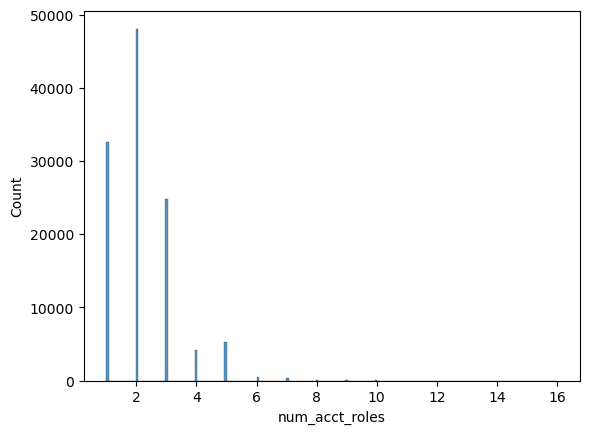

In [17]:
display(final_df['num_acct_roles'].describe())
print(df_acctroles_count['num_acct_roles'].median())
sns.histplot(data=final_df, x='num_acct_roles');

## ACTV - account activity
## Account Longevity
`days_active` - continuous {days} - how long has it been since the account was opened?
* `ACCT.CONTRACTDATE` & `WINDOW_END` are used to determine how long the account has been open
    - `CONTRACTDATE` is assumed to mean when the account contract documentation was signed & the account would be opened same-day or sometime after
    - ~1600 accounts show a contract date which occurs after our lookback window ends (i.e. after their account was closed) if we use `WINDOW_END_ADJ`.  This happens because we are trying not to use future data for our model -- 30-days prior to account closure means only data up to 30-days prior to an account being used. Unfortunately this also means that we will capture a negative account age in some cases as we set our account closure to 30-days before an account actually closes.
        * negative days should be avoided by relying on `WINDOW_END`

In [17]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acct_age = (
    oc_accounts
    .select('ACCTNBR', f.to_date('CONTRACTDATE').alias('CONTRACTDATE'), 'WINDOW_END_ADJ')
    .with_column(
        "acct_age_days", 
        f.expr("datediff(day, CONTRACTDATE, '2022-08-01')") 
        # datediff('day', col('CONTRACTDATE'), '8/1/2022')  # fixed date not accepted
    )
    .select('ACCTNBR', 'ACCT_AGE_DAYS')
)
  
print(sdf_acct_age.count())
sdf_acct_age.show()
print("number of lookback accounts missing 'CONTRACTDATE':", sdf_acct_age.filter(f.is_null(col('ACCT_AGE_DAYS'))).count())

In [18]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_acct_age = sdf_acct_age.to_pandas()
final_df = pd.merge(final_df, df_acct_age, left_on='ACCTNBR', right_on='ACCTNBR', how='left')

# There are numerous accounts which span decades & therefore we use the median to avoid influence from extreme outliers
final_df['ACCT_AGE_DAYS'] = final_df['ACCT_AGE_DAYS'].fillna(final_df['ACCT_AGE_DAYS'].median())
final_df['ACCT_AGE_DAYS'] = final_df['ACCT_AGE_DAYS'].astype('int')
final_df

count    116000.000000
mean       3113.006069
std        3312.162235
min           0.000000
25%         965.000000
50%        1918.000000
75%        3847.000000
max       20332.000000
Name: ACCT_AGE_DAYS, dtype: float64

1918.0


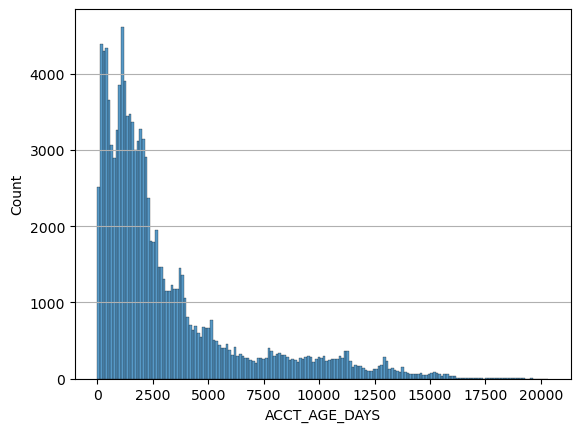

In [33]:
display(final_df['ACCT_AGE_DAYS'].describe())
print(final_df['ACCT_AGE_DAYS'].median())
sns.histplot(data=df_acct_age, x='ACCT_AGE_DAYS');
plt.grid(axis='y')

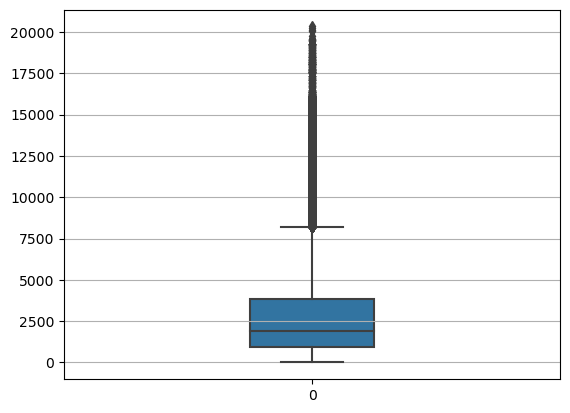

In [34]:
sns.boxplot(final_df['ACCT_AGE_DAYS'], width=0.25, dodge=True);
plt.grid(axis='y')

## Total number of accounts for primary account holder during lookback period
* incomplete data - unable to use

In [93]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_prim_own_num_accts = (
    oc_accounts
    .join(
        snow_session.table('acctacctrolepers'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('pers')['persnbr'],
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('EFFDATE') < col('WINDOW_END_ADJ'))   # 'INACTIVEDATE' appears to not be used frequently
    )
    .select('PERSNBR', 'ACCTNBR')
)

print(sdf_prim_own_num_accts.distinct().sort('ACCTNBR').count())
# sdf_prim_own_num_accts.distinct().sort('PERSNBR').show()

# Determine the number of accounts per person
# sdf_prim_own_num_accts.distinct().group_by('PERSNBR').count().sort('COUNT', ascending=False).show()

101212


In [22]:
# join number of accounts per person back to accounts table via the recorded primary account holder captured
df_num_acct_per_pers = sdf_prim_own_num_accts.distinct().group_by('PERSNBR').count()

sdf_acct_persn = (
    oc_accounts
    .join(
        df_num_acct_per_pers,
        on=oc_accounts['TAXRPTFORPERSNBR']==df_num_acct_per_pers['persnbr'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', col('COUNT').alias('acct_per_pers'))
)

# sdf_acct_persn.show()
sdf_acct_persn.select(f.median('ACCT_PER_PERS')).show()
sdf_acct_persn.select('ACCT_PER_PERS').describe().show()

-------------------------------
|"MEDIAN(""ACCT_PER_PERS"")"  |
-------------------------------
|2.000                        |
-------------------------------

----------------------------------
|"SUMMARY"  |"ACCT_PER_PERS"     |
----------------------------------
|mean       |2.374007            |
|max        |36.0                |
|count      |127789.0            |
|stddev     |1.7269394893857746  |
|min        |1.0                 |
----------------------------------



In [37]:
# UNFORUNATELY, 63% of 'acct_per_pers' values are missing for respective accounts -- we cannot use this feature
df_acct_persn = sdf_acct_persn.to_pandas()
pd.merge(final_df, df_acct_persn, left_on='ACCTNBR', right_on='ACCTNBR', how='left')['ACCT_PER_PERS'].value_counts(dropna=False)

NaN     72813
1.0     22787
2.0     11030
3.0      4981
4.0      2152
5.0       926
6.0       546
7.0       245
8.0       160
10.0      100
9.0        45
13.0       39
19.0       38
35.0       35
11.0       33
15.0       30
14.0       28
12.0       12
Name: ACCT_PER_PERS, dtype: int64

## NSF
`nsf_fees` - binary {Y:1, N:0} - were there at least 1 non-sufficient funds fee assessed during the lookback period?
* While we find that while not every mbr has NSF issues some of the mbrs that do, have *many* non-sufficient fund fees
* ~10% of mbrs had NSF fees during the lookback period

In [23]:
sdf_stat_nsf = (
    oc_accounts
    .join(
        snow_session.table('acctstatistichist'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Statistictyp'),
        on='STATISTICTYPCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'STATISTICTYPDESC')
    .filter(
        (col('STATISTICTYPDESC') == 'Insufficient Funds Totals') & 
        (col('YEARNBR') == 2022) & 
        (col('MONTHCD') >= 1) & 
        (col('MONTHCD') < f.date_part('month', col('WINDOW_END_ADJ')))  
    )
)
# NOTE: we may have up to an extra 30-days [forecasting], however, accuracy is to the month-level 
# better to have than not

print('Total NSF Fees:', sdf_stat_nsf.count())
print('Number Mbr Accounts w/ NSF Fees:', sdf_stat_nsf.distinct().count())
print(f"Avg NSF fees per accounts which have them: {sdf_stat_nsf.count()/sdf_stat_nsf.distinct().count()}")

# sdf_stat_nsf.sort('ACCTNBR').show()

Total NSF Fees: 51355
Number Mbr Accounts w/ NSF Fees: 20411
Avg NSF fees per accounts which have them: 2.5160452697075106


In [24]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_stat_nsf = sdf_stat_nsf.distinct().to_pandas()

def map_nsf_fees(row):
    if ['STATISTICTYPDESC'] is not None:
        return 1
    
df_stat_nsf['nsf_fees'] = df_stat_nsf['STATISTICTYPDESC'].apply(map_nsf_fees)
df_stat_nsf = df_stat_nsf[['ACCTNBR', 'nsf_fees']]
df_stat_nsf.head()

In [25]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

final_df = pd.merge(final_df, df_stat_nsf, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['nsf_fees'].fillna(0, inplace=True)
final_df['nsf_fees'] = final_df['nsf_fees'].astype('int')
final_df

## Uncollected Funds
`uncollected_funds` - binary {Y:1, N:0} - were there uncollected funds under a given account during the lookback period?

In [26]:
sdf_stat_uncollected = (
    oc_accounts
    .join(
        snow_session.table('acctstatistichist'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Statistictyp'),
        on='STATISTICTYPCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'STATISTICTYPDESC')
    .filter(
        (col('STATISTICTYPDESC') == 'Uncollected Funds Totals') & 
        (col('YEARNBR') == 2022) & 
        (col('MONTHCD') >= 1) & 
        (col('MONTHCD') < f.date_part('month', col('WINDOW_END_ADJ')))  
    )
)
# NOTE: we may have up to an extra 30-days [forecasting], however, accuracy is to the month-level 
# better to have than not

print('Total :', sdf_stat_uncollected.count())
print('Number Mbr Accounts w/:', sdf_stat_uncollected.distinct().count())
print(f"Avg per accounts which have them: {sdf_stat_uncollected.count()/sdf_stat_uncollected.distinct().count()}")

# sdf_stat_uncollected.sort('ACCTNBR').show()

Total : 93
Number Mbr Accounts w/: 72
Avg per accounts which have them: 1.2916666666666667


In [28]:
df_stat_uncollected = sdf_stat_uncollected.distinct().to_pandas()

def map_uncollected_funds(row):
    if ['STATISTICTYPDESC'] is not None:
        return 1
    
df_stat_uncollected['uncollected_funds'] = df_stat_uncollected['STATISTICTYPDESC'].apply(map_uncollected_funds)
df_stat_uncollected = df_stat_uncollected[['ACCTNBR', 'uncollected_funds']]

In [29]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

final_df = pd.merge(final_df, df_stat_uncollected, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['uncollected_funds'].fillna(0, inplace=True)
final_df['uncollected_funds'] = final_df['uncollected_funds'].astype('int')
final_df

## ATM Withdrawals
`atm_withdr` - binary {Y:1, N:0} - were there ATM withdrawals for a given account during the lookback period?

In [30]:
sdf_stat_atm = (
    oc_accounts
    .join(
        snow_session.table('acctstatistichist'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Statistictyp'),
        on='STATISTICTYPCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'STATISTICTYPDESC')
    .filter(
        (col('STATISTICTYPDESC') == 'Total ATM Withdrawals') & 
        (col('YEARNBR') == 2022) & 
        (col('MONTHCD') >= 1) & 
        (col('MONTHCD') < f.date_part('month', col('WINDOW_END_ADJ')))  
    )
)
# NOTE: we may have up to an extra 30-days [forecasting], however, accuracy is to the month-level 
# better to have than not

print('Total :', sdf_stat_atm.count())
print('Number Mbr Accounts w/:', sdf_stat_atm.distinct().count())
print(f"Avg per accounts which have them: {sdf_stat_atm.count()/sdf_stat_atm.distinct().count()}")

# sdf_stat_atm.sort('ACCTNBR').show()

Total : 356062
Number Mbr Accounts w/: 80289
Avg per accounts which have them: 4.434754449550997


In [31]:
df_stat_atm = sdf_stat_atm.distinct().to_pandas()

def map_atm(row):
    if ['STATISTICTYPDESC'] is not None:
        return 1
    
df_stat_atm['atm_withdr'] = df_stat_atm['STATISTICTYPDESC'].apply(map_atm)
df_stat_atm = df_stat_atm[['ACCTNBR', 'atm_withdr']]

In [32]:
final_df = pd.merge(final_df, df_stat_atm, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['atm_withdr'].fillna(0, inplace=True)
final_df['atm_withdr'] = final_df['atm_withdr'].astype('int')
# final_df

## Account Past Due?
`past_due` - binary {Y:1, N:0} - was the account past due for payment(s) during the lookback period?

In [33]:
sdf_stat_pastdue = (
    oc_accounts
    .join(
        snow_session.table('acctstatistichist'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Statistictyp'),
        on='STATISTICTYPCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'STATISTICTYPDESC')
    .filter(
        (col('STATISTICTYPDESC') == 'Past Due') & 
        (col('YEARNBR') == 2022) & 
        (col('MONTHCD') >= 1) & 
        (col('MONTHCD') < f.date_part('month', col('WINDOW_END_ADJ')))  
    )
)
# NOTE: we may have up to an extra 30-days [forecasting], however, accuracy is to the month-level 
# better to have than not

print('Total :', sdf_stat_pastdue.count())
print('Number Mbr Accounts w/:', sdf_stat_pastdue.distinct().count())
print(f"Avg per accounts which have them: {sdf_stat_pastdue.count()/sdf_stat_pastdue.distinct().count()}")

# sdf_stat_pastdue.sort('ACCTNBR').show()

Total : 12411
Number Mbr Accounts w/: 4290
Avg per accounts which have them: 2.893006993006993


In [34]:
df_stat_pastdue = sdf_stat_pastdue.distinct().to_pandas()

def map_pastdue(row):
    if ['STATISTICTYPDESC'] is not None:
        return 1
    
df_stat_pastdue['past_due'] = df_stat_pastdue['STATISTICTYPDESC'].apply(map_pastdue)
df_stat_pastdue = df_stat_pastdue[['ACCTNBR', 'past_due']]

In [35]:
final_df = pd.merge(final_df, df_stat_pastdue, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['past_due'].fillna(0, inplace=True)
final_df['past_due'] = final_df['past_due'].astype('int')
# final_df

## Account Available Amount History
This feature provides us with available account amounts throughout the lookback period for each respective account located.
* ~ half of accounts have an entry within the `acctavailamthist` table for our lookback period -- **we forego this feature**

* Account available amount represents the **available amount someone has within their account to withdrawal**
* We must filter our results using the column `ACCTAVAILAMTHIST.EFFDATE` to determine account available amounts which occured during the lookback period, only.
    - `EFFDATE` is the date that the account available amount became effective, representing the result of transactional activity on said account
* We perform aggregation on the available amount to arrive at a value representing the average account available amount
    - the average is not robust to outliers which is desired in this case as extremes in either direction can help cue us in on overall account activity
    - Minimum account available amount is an alternative aggregation measure to be used for the lookback period
* We find that there are not entries (available amount updates) for every account within the lookback account which indicates an account available amount may not have changed during the lookback period

In [36]:
# average should exclude 30 days leading up to closure date, for closed accounts
# don't give model glimpse into future

oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acctavailamthist = (
    oc_accounts
.join(
    snow_session.table('acctavailamthist'),
    on='ACCTNBR',
    how='inner',
    rsuffix='_'
).filter(   # use an additional 90-day window prior to start to capture more values: only ~1.2K more values added
    (f.to_date('EFFDATE') >= '9/30/2021') & (f.to_date('EFFDATE') < col('WINDOW_END_ADJ'))   
).group_by(
    'ACCTNBR'
).agg(f.avg('AVAILAMT').alias('avg_availamt')   # can also use median, sum, stddev
)
)

print(f"{sdf_acctavailamthist.count()/oc_accounts.count():.2%} of accounts have an availamt for the lookback period")
# sdf_acctavailamthist.show()
df_acctavailamthist_avg = sdf_acctavailamthist.to_pandas()

51.10% of accounts have an availamt for the lookback period


## Account Balance History
`AVG_ACCT_BAL` - continuous ($) - This feature provides us with the account balance throughout the lookback period for each respective account located and the median for any missing accounts.

* Account balance represents the balance (dollar amount) someone has on their account
* We must filter our results using the column `ACCTBALHIST.EFFDATE` to determine account available amounts which occured during the lookback period, only.
    - `EFFDATE` is the date that the account balance changed, representing the result of transactional activity on said account
    - we use a 90-day window here as we are aggregating and wish to avoid missing peripheral activity; however we leave the 30-day closure lead time without change
* We perform aggregation on the available amount to arrive at a value representing the average account available amount
    - the average is not robust to outliers which is desired in this case as extremes in either direction can help cue us in on overall account activity
    - Minimum account available amount is a suitable alternative aggregation measure to be used for the lookback period in this case
* We find that there are not entries (available amount updates) for every account within the lookback account which indicates an account available amount may not have changed during the lookback period

In [37]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acctbalhist = (
    oc_accounts
    .join(
        snow_session.table('acctbalhist'.upper()),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .filter(   # by expanding our start window to 90-days (3-months) prior we capture an additional 8.3K values
        (f.to_date('EFFDATE') >= '9/30/2021') & (f.to_date('EFFDATE') < col('WINDOW_END_ADJ'))
    )
    .group_by('ACCTNBR').agg(f.avg('balamt').alias('avg_acct_bal')   # can also use median, sum, stddev
    )
)

print(f"{sdf_acctbalhist.count()/oc_accounts.count():.2%} of accounts have an acctbalhist for the lookback period + 3-months")
print(sdf_acctbalhist.count())
# sdf_acctbalhist.show()

68.24% of accounts have an acctbalhist for the lookback period + 3-months
205726


In [38]:
df_acctbalhist = sdf_acctbalhist.to_pandas()
final_df = pd.merge(final_df, df_acctbalhist, on='ACCTNBR', how='left')
final_df['AVG_ACCT_BAL'] = final_df['AVG_ACCT_BAL'].fillna(final_df['AVG_ACCT_BAL'].median())  # use the median of average account balance for those accounts missing this value for the lookback period
display(final_df.isna().sum())
# final_df

ACCTNBR              0
trxn_acct            0
retire_acct          0
stmnt_acct           0
ACCT_OPEN            0
num_acct_roles       0
ACCT_AGE_DAYS        0
nsf_fees             0
uncollected_funds    0
atm_withdr           0
past_due             0
AVG_ACCT_BAL         0
dtype: int64

## Account Lockout Notifications
`acctlockoutflag` - binary {Y:1, N:0} - did an account have at least 1 active lockout flag during the lookback period?


* During the lookback period was there an account assigned a lockout flag, impeding account usage?
* EFFDATE is the date the account lockout took effect
* INACTIVEDATE is the date the lockout was no longer in effect.

In [39]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acctlockout = (
    oc_accounts
    .join(
        snow_session.table('acctlockout'),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('EFFDATE') < col('WINDOW_END_ADJ'))
    )
    .filter(
        (f.to_date('INACTIVEDATE') >= col('WINDOW_START'))
    )
    .join(
        snow_session.table('Lockoutflag'),
        on='lockoutflagcd',
        how='inner',
        rsuffix='+'
    )
    .select(
        'ACCTNBR', 
        'LOCKOUTFLAGDESC', 
        f.to_date(col('EFFDATE')).alias('effective'), 
        f.to_date(col('INACTIVEDATE')).alias('inactive')
    )
)

# sdf_acctlockout.show()
df_acctlockout = sdf_acctlockout.to_pandas()

In [40]:
print(sdf_acctlockout.count())
sdf_acctlockout.group_by(col('LOCKOUTFLAGDESC')).count().order_by('count', ascending=False).show()

# this reveals to us that several members have had multiple account lockoutflags for the lookback period
# we will assign a lockout flag if 1 or more lockout flags were assigned to an account during the lookback period
# sdf_acctlockout.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).show()

sdf_acctlockout.select(f.min('EFFECTIVE')).show()
sdf_acctlockout.select(f.max('INACTIVE')).show()

9841
--------------------------------------------
|"LOCKOUTFLAGDESC"               |"COUNT"  |
--------------------------------------------
|No Withdrawals                  |2475     |
|No Transactions Call Collectns  |2204     |
|No WIthdrawals-Call Collection  |1377     |
|Repossession AMS Code           |1042     |
|No Transactions Call Fraud      |680      |
|Deceased                        |523      |
|Bankruptcy in Process           |226      |
|Employee Account                |216      |
|Membership Account Transaction  |214      |
|BSA Missing Information         |190      |
--------------------------------------------

------------------------
|"MIN(""EFFECTIVE"")"  |
------------------------
|2001-06-29            |
------------------------

-----------------------
|"MAX(""INACTIVE"")"  |
-----------------------
|2099-11-15           |
-----------------------



In [41]:
df_acctlockout = df_acctlockout[['ACCTNBR']]
df_acctlockout.drop_duplicates(inplace=True)
df_acctlockout['acctlockoutflag'] = 1
# df_acctlockout

In [42]:
final_df = pd.merge(final_df, df_acctlockout, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['acctlockoutflag'].fillna(0, inplace=True)
final_df['acctlockoutflag'] = final_df['acctlockoutflag'].astype('int')
# final_df

In [57]:
final_df['acctlockoutflag'].value_counts() / len(final_df)

0    0.968638
1    0.031362
Name: acctlockoutflag, dtype: float64

## Education Level
* This attribute describes the highest education level the member has attained
* Forced to drop this feature due to large number of missing values for our lookback population
    - only 14/116,000=0.01% accounts have an associated education for the primary account owner

In [43]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_education = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('EDUCLEV'),
        on='EDUCLEVCD',
        how='inner',
        rsuffix='+'
    )
    .select('ACCTNBR', 'EDUCLEVDESC')
)

# sdf_education.show()
print(sdf_education.count())
sdf_education.group_by(col('EDUCLEVDESC')).count().order_by('count', ascending=False).show()

42
------------------------------------
|"EDUCLEVDESC"           |"COUNT"  |
------------------------------------
|High School             |25       |
|Bachelors Degree        |12       |
|High School Equivalent  |3        |
|Masters Degree          |2        |
------------------------------------



## Account Type Identification
`acct_type` - categorical - 12 levels representing a mid-level category the account type falls into (checking, savings, mortgage loan, etc.)

This is the basic categorical type of financial product offered by an institution and is a step above product-level, however, this is not a high-level product type categorization as is found for `MJACCTTYPCATDESC` below.

In [44]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_mjaccttyp = (
    oc_accounts
    .join(
        snow_session.table('mjaccttyp'),
        on='MJACCTTYPCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', col('MJACCTTYPDESC').alias('acct_type'))
)

print(sdf_mjaccttyp.count())    # all 116K accounts have been assigned a product type!
# sdf_mjaccttyp.sort('ACCTNBR', ascending=True).show()
print(sdf_mjaccttyp.group_by(col('acct_type')).count().order_by('count', ascending=False).count())
sdf_mjaccttyp.group_by(col('acct_type')).count().order_by('count', ascending=False).show(12)

301456
12
-------------------------------------
|"ACCT_TYPE"              |"COUNT"  |
-------------------------------------
|Checking                 |173341   |
|Savings                  |59532    |
|Externally Serviced      |34080    |
|Consumer Loan            |26045    |
|Time Deposit             |3358     |
|Master Line              |2288     |
|Mortgage Loan            |1754     |
|Retirement Account       |511      |
|General Ledger           |367      |
|Commercial Loan          |171      |
|Official Check Accounts  |6        |
|Regulatory Reporting     |3        |
-------------------------------------



In [45]:
df_mjaccttyp = sdf_mjaccttyp.to_pandas()
final_df = pd.merge(final_df, df_mjaccttyp, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
# final_df

## Highest-Level Categories for Account Types/Financial Products Offered at Bellco
This attribute represents the highest categorical classification of financial product offered by an institution. We forego this feature.

In [46]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_mjaccttyp = (
    oc_accounts
    .join(
        snow_session.table('mjaccttyp'),
        on='MJACCTTYPCD',
        how='inner',
        rsuffix='_'
    )
    .join(snow_session.table('mjaccttypcat'),
        on='MJACCTTYPCATCD',
        how='inner',
        rsuffix='_'
    )
    
    .select('ACCTNBR', 'MJACCTTYPDESC', 'MJACCTTYPCATDESC')
)

print(sdf_mjaccttyp.count())    # all 116K accounts have an assigned product type!
# sdf_mjaccttyp.show(20)
print(sdf_mjaccttyp.group_by(col('MJACCTTYPCATDESC')).count().order_by('count', ascending=False).count())
sdf_mjaccttyp.group_by(col('MJACCTTYPCATDESC')).count().order_by('count', ascending=False).show()

301456
6
----------------------------------
|"MJACCTTYPCATDESC"    |"COUNT"  |
----------------------------------
|Deposit               |236231   |
|External Entities     |34080    |
|Loan                  |30258    |
|Retirement            |511      |
|Other                 |373      |
|Regulatory Reporting  |3        |
----------------------------------



## Product-level Bellco offering
This attribute represents a product-level classification where there are 10 products listed for the lookback period.  We forego this feature.
* 'Free' is thought to be shorthand or a typographical error for 'Free Checking'
* there are 174 different products listed which presents a potential problem for 1-hot/dummy categorical encoding

* Note to self: either use product & major or just product

In [47]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_product = (
    oc_accounts
    .join(
        snow_session.table('Mjmiaccttyp'),
        on=oc_accounts['CURRMIACCTTYPCD']==snow_session.table('Mjmiaccttyp')['MIACCTTYPCD'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', col('MIACCTTYPDESC').alias('product'))
)

print(sdf_product.count())    # all 116K accounts have an assigned product type!
# sdf_product.sort('ACCTNBR', ascending=True).show()
print(sdf_product.group_by(col('product')).count().order_by('count', ascending=False).count())
sdf_product.group_by(col('product')).count().order_by('count', ascending=False).show(30)

301456
184
-------------------------------------------
|"PRODUCT"                      |"COUNT"  |
-------------------------------------------
|Free                           |61638    |
|Boost Interest Checking        |56696    |
|Platinum Checking              |21655    |
|Visa Platinum Credit Card      |16829    |
|Visa Platinum Rewards          |16237    |
|Statement Account              |15783    |
|Student Checking               |15713    |
|Savings                        |11852    |
|Primary                        |10591    |
|Free Business Checking         |10240    |
|Membership Account             |8988     |
|CUDC Auto Used                 |8818     |
|Youth Account                  |5779     |
|Charged Off Checking           |4854     |
|Auto Used                      |2461     |
|Home Equity ChoiceLine         |2288     |
|CUDC Auto New                  |2099     |
|Max Checking                   |2006     |
|Premier Money Market           |1874     |
|Line of Credit      

## Account Ownership Type
`own_single` - binary {Y:1, N:0} - if 1 then this account is solely owned, otherwise the account has joint ownership

This features designates if the account in question is either solely, or jointly owned.

In [48]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_owntyp = (
    oc_accounts
    .join(
        snow_session.table('Owntyp'),
        on='OWNCD',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'OWNDESC')
)

print(sdf_owntyp.count())
# sdf_owntyp.show()
sdf_owntyp.group_by(col('OWNDESC')).count().order_by('count', ascending=False).show()

301456
-----------------------
|"OWNDESC"  |"COUNT"  |
-----------------------
|Single     |175204   |
|Joint OR   |118929   |
|Joint And  |7323     |
-----------------------



In [49]:
df_owntyp = sdf_owntyp.to_pandas()

def single_owner_map(row):
    if row == 'Single':
        return 1
    else:
        return 0
    
def joint_ownership_map(row):
    if row == 'Joint OR' or row == 'Joint And':
        return 1
    else:
        return 0


df_owntyp['acct_solo'] = df_owntyp['OWNDESC'].apply(single_owner_map)
df_owntyp = df_owntyp[['ACCTNBR', 'acct_solo']]

final_df = pd.merge(final_df, df_owntyp, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
# final_df

## Account Owner Age
`acct_own_age` - continuous {2:108 years old} - derived from reported birthdate, which appears conspicuously missing for a fraction of the population.  The median age has been used to determine these missing values.

In [51]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acctowner_age = (
    oc_accounts
    .join(
        snow_session.table('pers'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('pers')['persnbr'],
        how='inner',
        rsuffix='_'
    )
    .with_column(
        "acct_own_age", 
        datediff( 'year', f.to_date(col("datebirth")), current_date() ))
).select('ACCTNBR', col('acct_own_age'))


# print(f"{sdf_acctowner_age.count():,} accounts w/ a respective DOB provided or {sdf_acctowner_age.count()/len(final_df):.2%}")
# sdf_acctowner_age.show()
sdf_acctowner_age.group_by(col('acct_own_age')).count().order_by('count', ascending=False).collect()   # shows 10 results by default
sdf_acctowner_age.group_by(col('acct_own_age')).count().order_by('count', ascending=False).show()

----------------------------
|"ACCT_OWN_AGE"  |"COUNT"  |
----------------------------
|53              |5593     |
|54              |5425     |
|52              |5392     |
|55              |5245     |
|60              |5171     |
|63              |5154     |
|61              |5082     |
|64              |5059     |
|59              |5058     |
|62              |5008     |
----------------------------



count    111289.000000
mean         49.662339
std          18.016613
min           2.000000
25%          35.000000
50%          50.000000
75%          64.000000
max         108.000000
Name: ACCT_OWN_AGE, dtype: float64

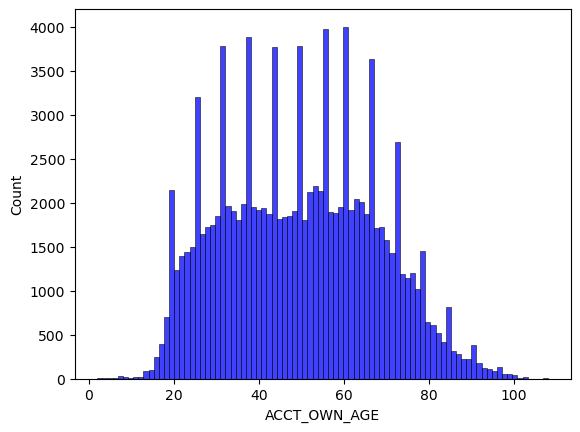

In [66]:
df_owner_age = sdf_acctowner_age.to_pandas()
sns.histplot(df_owner_age['ACCT_OWN_AGE'], color='blue');
df_owner_age['ACCT_OWN_AGE'].describe()

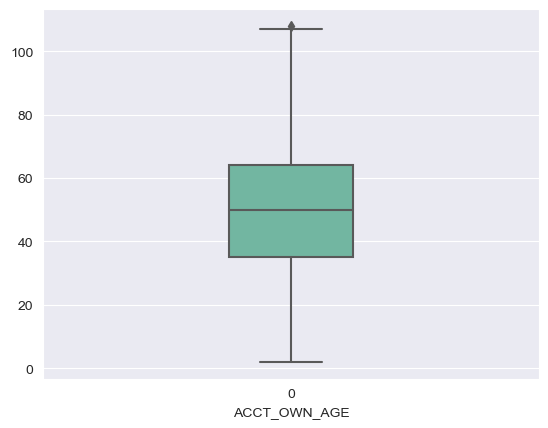

In [67]:
sns.set_style('darkgrid')
sns.set_palette('Set2')
sns.boxplot(df_owner_age['ACCT_OWN_AGE'], width=0.25);
plt.xlabel('ACCT_OWN_AGE');

In [52]:
df_age = sdf_acctowner_age.to_pandas()
final_df = pd.merge(final_df, df_age, left_on='ACCTNBR', right_on='ACCTNBR', how='left')

# fill-in missing age values (NA) w/ the median age
final_df['ACCT_OWN_AGE'] = final_df['ACCT_OWN_AGE'].fillna(final_df['ACCT_OWN_AGE'].median())
final_df['ACCT_OWN_AGE'] = final_df['ACCT_OWN_AGE'].astype('int')
# final_df

## Marital Status
* largely blank -- cannot use unfortunately

In [53]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_marital_status = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'spousepersnbr')
)

# sdf_marital_status.show()
print(sdf_marital_status.count())
sdf_marital_status.group_by(col('SPOUSEPERSNBR')).count().order_by('count', ascending=False).show()

288273
-----------------------------
|"SPOUSEPERSNBR"  |"COUNT"  |
-----------------------------
|NULL             |285826   |
|70535            |20       |
|141704           |12       |
|5544             |12       |
|119710           |11       |
|134435           |10       |
|167723           |9        |
|117584           |8        |
|12886            |8        |
|259100           |7        |
-----------------------------



## Income Level
* largely blank -- cannot use unfortunately

In [54]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_income_level = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'incomelevcd')
)

# sdf_income_level.show()
print(sdf_income_level.count())
sdf_income_level.group_by(col('incomelevcd')).count().order_by('count', ascending=False).show()

288273
---------------------------
|"INCOMELEVCD"  |"COUNT"  |
---------------------------
|NULL           |288273   |
---------------------------



## Number of Dependents reported for Primary Account Owner
* largely blank -- cannot use unfortunately

In [55]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_nbr_dep = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'nbrdepnd')
)

# sdf_nbr_dep.show()
print(sdf_nbr_dep.count())
sdf_nbr_dep.group_by(col('nbrdepnd')).count().order_by('count', ascending=False).show()

288273
------------------------
|"NBRDEPND"  |"COUNT"  |
------------------------
|NULL        |287394   |
|0           |874      |
|2           |4        |
|1           |1        |
------------------------



## Primary Account Owner's Occupation
* all null values

In [56]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_occupation = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'occptncd')
)

# sdf_occupation.show()
print(sdf_occupation.count())
sdf_occupation.group_by(col('occptncd')).count().order_by('count', ascending=False).show()

288273
------------------------
|"OCCPTNCD"  |"COUNT"  |
------------------------
|NULL        |288273   |
------------------------



## Does the Primary Account Owner Rent or Own?
* largely blank -- cannot use unfortunately

In [57]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_nbr_dep = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'ownrent')
)

# sdf_nbr_dep.show()
print(sdf_nbr_dep.count())
sdf_nbr_dep.group_by(col('ownrent')).count().order_by('count', ascending=False).show()

288273
-----------------------
|"OWNRENT"  |"COUNT"  |
-----------------------
|NULL       |262574   |
|R          |13391    |
|O          |12308    |
-----------------------



## Was the Primary Account Owner Validated?
`own_valid` - binary {1:Yes, 0:No} - Did the account owner pass Bellco's validation protocol?
* Did the account owner pass Bellco's validation protocol? This is a parameter without explanation, where the validation procedure remains unknown to this author, but is captured here nonetheless. 
Useable, however, related information concerning the ID type in-file has been collected which obviates the need for this feature

In [61]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_valid = (
    oc_accounts
    .join(
        snow_session.table('PERS'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('PERS')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'validyn')
)

# sdf_valid.show()
print(sdf_valid.count())
sdf_valid.group_by(col('validyn')).count().order_by('count', ascending=False).show()
df_valid = sdf_valid.to_pandas()
df_valid.rename(columns={'VALIDYN': 'own_valid'}, inplace=True)

288273
-----------------------
|"VALIDYN"  |"COUNT"  |
-----------------------
|Y          |254217   |
|N          |34056    |
-----------------------



In [62]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

final_df = pd.merge(final_df, df_valid, left_on='ACCTNBR', right_on='ACCTNBR', how='left')
final_df['own_valid'] = final_df['own_valid'].fillna(final_df['own_valid'].mode().values[0])
final_df['own_valid'] = final_df['own_valid'].map({'Y':1, 'N':0})
final_df['own_valid'] = final_df['own_valid'].astype('int')
final_df.value_counts(dropna=False)
# final_df

## Credit Score
`credit_score` - continuous {300-850}/categorical - The primary account owner's average credit score for the lookback period 1/1/2022 - 8/1/2022
* In my experience working within finance it is much easier for an individual's credit score to drop than it is to build the score up (the latter taking years in most cases).  Therefore using the minimum credit score for the lookback period is the most illustrative approach.
* It is not known to me when Bellco chooses to run credit reports on its members throughout any year (monthly, quarterly, etc).  A filter is needed, however, which captures when the credit score was determined and exists via `PERSCREDITSCOREHIST.SCOREDATE`.  It's possible that for transactional accounts in good standing Bellco only runs credit reports every several years, or does not run a credit report at all for a member, if they are in good standing, if they have no loans concurrently with Bellco.
    - a filter upper bound is needed as we are only concerned with credit bureaus up through the end of our lookback period
    - a filter lower bound is more interesting: if we set the lower bound for our credit bureau score to the start of our lookback window then we obtain credit scores for only ~66% of the population. However if we set no lower bound then we find we obtain credit scores for 90% of our population. Therefore no lower bound has been set.  This will give us a much better idea of credit scores, as an estimation, for members who would otherwise have to be estimated through imputation based off of other members' histories vs estimating based off an individual's credit history.
* To avoid missing invaluble credit bureau reporting prior to the lookback window, we drop the lower limit for when a credit bureau report was taken as we are looking in aggregate for the lowest credit bureau score
    - We avoid missing credit reports due to gaps in reporting
        * e.g. (hypothetical) a CBR is taken every 2 years for transactional accounts in good standing, and the latest report in the series for a given account falls just below our lower window threshold, therefore we would not be able to see the score
    - if a CBR was generated at any point in time for an individual this is better to use as a basis than to impute for a collective group of individuals potentially very different from a given account owner
* ~10% of the population is imputed (median) due to missing values
* Credit scores are categorical rather than continuous and as such **binning** is used -- see below

In [65]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_credit_score = (
    oc_accounts
    .join(
        snow_session.table('perscreditscorehist'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('perscreditscorehist')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .filter((f.to_date('SCOREDATE') < col('WINDOW_END_ADJ'))
    )
    .group_by('ACCTNBR').agg(f.min('CREDITSCORE').alias('CREDITSCORE'))   # max/min/avg
)

# sdf_credit_score.show()
print(f"{sdf_credit_score.count()/oc_accounts.count():.2%} of all values have a credit score")
df_credit_score = sdf_credit_score.to_pandas()
# df_credit_score

72.27% of all values have a credit score


### several spurious values exist which must be addressed
credit score: 
    - min: 0 (300 is min)
    - >900: 9002, 9003 (vs 900 max possible for some Credit Bureau Report scales)

In [66]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

df_credit_score[df_credit_score['CREDITSCORE'] > 900]

In [80]:
print("No Adjustment:")
print('Min value:', df_credit_score['CREDITSCORE'].min())
print('Max value:', df_credit_score['CREDITSCORE'].max())

# Drop the problematic credit scores: 0, 9002, 9003
df_credit_score = df_credit_score[df_credit_score['CREDITSCORE'] != df_credit_score['CREDITSCORE'].min()]
df_credit_score.drop(df_credit_score[df_credit_score['CREDITSCORE'] > 900].index, inplace=True)

print("\nAfter Adjustment:")
print('Min value:', df_credit_score['CREDITSCORE'].min())
print('Max value:', df_credit_score['CREDITSCORE'].max())

No Adjustment:
Min value: 0.0
Max value: 9003.0

After Adjustment:
Min value: 374.0
Max value: 842.0


C:\Users\jcorley\AppData\Local\Temp\ipykernel_11608\3025815749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit_score.drop(df_credit_score[df_credit_score['CREDITSCORE'] > 900].index, inplace=True)


In [81]:
df_credit_score['CREDITSCORE'].describe()

count    104223.000000
mean        655.318932
std          94.258930
min         374.000000
25%         588.000000
50%         667.000000
75%         733.000000
max         842.000000
Name: CREDITSCORE, dtype: float64

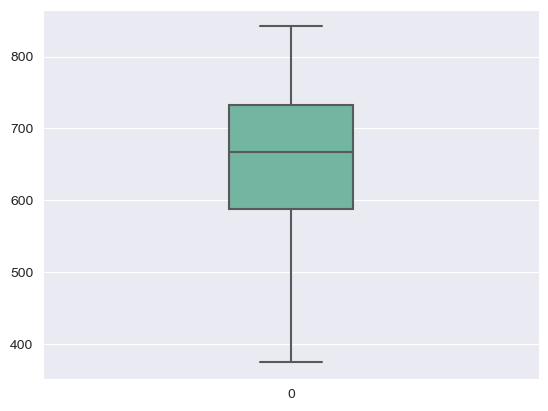

In [82]:
sns.boxplot(df_credit_score['CREDITSCORE'], width=0.25);

### Fill-in Missing Values & Bin
The chosen scale varies depending on the credit bureau and opinion of the individual--we could not find who Bellco uses for scoring its members within the underlying database as the associated table was unavailable. The following scoring is assumed, as it's common in finance:
* Excellent: 800 - 850
* Very Good: 750 - 799 
* Good: 700 - 749
* Fair: 650 - 699
* Poor: 600 - 649
* Bad: 300 - 599

In [83]:
# Impute missing credit score w/ median credit score for ~ 1/3 of values (not ideal but time constraint)
df_credit_score['CREDITSCORE'].fillna(df_credit_score['CREDITSCORE'].median(), inplace=True)
print(df_credit_score.isna().sum())

ACCTNBR        0
CREDITSCORE    0
dtype: int64


C:\Users\jcorley\AppData\Local\Temp\ipykernel_11608\434673740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_credit_score['CREDITSCORE'].fillna(df_credit_score['CREDITSCORE'].median(), inplace=True)


In [67]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

# Bin 

# display(df_credit_score['CREDITSCORE'])

df_credit_score['credit_cat'] = pd.cut(
    df_credit_score['CREDITSCORE'], 
    right=False,   # include right endpoint
    bins=[300, 600, 650, 700, 750, 800, 851], 
    labels=['bad', 'poor', 'fair', 'good', 'very good', 'excellent']
)

display(df_credit_score)
sns.histplot(data=df_credit_score, x='CREDITSCORE', hue='credit_cat', palette='viridis');

df_credit_score = df_credit_score[['ACCTNBR', 'credit_cat']]

In [68]:
final_df = pd.merge(final_df, df_credit_score, left_on='ACCTNBR', right_on='ACCTNBR', how='left')

# fillna() expects scalar or same-length Series
final_df['credit_cat'] = final_df['credit_cat'].fillna(final_df['credit_cat'].mode().values[0])  
# final_df

## ID Type used to Verify the Primary Account Holder
* encode this feature & skip verification Y/N table. We forego this feature -- see notes below
* we might encode a binary feature for military ID in the future

In [69]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_primary_id = (
    oc_accounts
    .join(
        snow_session.table('persid'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('persid')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Persidtyp'),
        on='PERSIDTYPCD',
        how='inner',
        rsuffix='+'
    )
    .select(
        'ACCTNBR', 
        'PERSIDTYPDESC', 
        f.to_date('LASTVERIFICATIONDATE').alias('LASTVERIFICATIONDATE'), 
        f.to_date('EXPIREDATE').alias('EXPIREDATE'),
        f.to_date('DATELASTMAINT').alias('DATELASTMAINT')
    )
)

# sdf_primary_id.show()
print(sdf_primary_id.count())
sdf_primary_id.group_by(col('PERSIDTYPDESC')).count().order_by('count', ascending=False).show()
# sdf_primary_id.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).show()
print(
    f"{sdf_primary_id.select(col('ACCTNBR')).distinct().count()/oc_accounts.count():.2%} of accounts have an id type listed")
sdf_primary_id.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).agg(f.avg('COUNT').alias('avg_num_id_per_acct_owner')).show()

549952
------------------------------
|"PERSIDTYPDESC"   |"COUNT"  |
------------------------------
|Driver's License  |281366   |
|Signature ID      |139149   |
|Fingerprint ID    |117629   |
|State ID          |4955     |
|Passport          |3076     |
|Resident Alien    |2879     |
|Visa              |466      |
|Military ID       |432      |
------------------------------

75.96% of accounts have an id type listed
-------------------------------
|"AVG_NUM_ID_PER_ACCT_OWNER"  |
-------------------------------
|2.401747                     |
-------------------------------



In [87]:
# determine how many accounts have X number of ID's: left column id count, right column frequency
sdf_primary_id.group_by(col('ACCTNBR')).count().group_by(col('COUNT')).count().show()

---------------------
|"COUNT"  |"COUNT"  |
---------------------
|6        |8        |
|4        |1200     |
|1        |56540    |
|5        |96       |
|2        |14223    |
|3        |37454    |
---------------------



In [70]:
df_primary_id = sdf_primary_id.to_pandas()
# df_primary_id

In [89]:
df_primary_id['PERSIDTYPDESC'].value_counts(dropna=False) / len(df_primary_id)

Driver's License    0.537301
Signature ID        0.241247
Fingerprint ID      0.201435
State ID            0.008462
Resident Alien      0.005028
Passport            0.004993
Visa                0.000780
Military ID         0.000755
Name: PERSIDTYPDESC, dtype: float64

In [71]:
# df_primary_id[df_primary_id['ACCTNBR'] == XXX]

### ID observations
It appears there is no ordering to ID's loaded into the system.  Important columns such as ISSUEDATE, EXPIREDATE, LASTVERIFICATIONDATE, which indicate when an ID was issued, expires, and last verfied are largely blank.
* It appears that if a Military ID or Resident Alien ID is present then there is a greater likelihood that other ID's will also be uploaded.
* this feature will not be used due to numerous accounts having multiple forms of ID uploaded
* possible avenue of exploration: if the mbr submits a fingerprint as a form of ID are they less likely to close their Bellco account?

## NAICS Service Industry Code 
Describes an industry affiliation
* NOTE: the SIC description table appears unavailable; this table would describe industries [for employment, etc.]

### Person-level SIC Code Assignment
* Do not use this mapping
    - There are 4 total results, including 2 null out of a possible 116K

In [72]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_pers_sic = (
    oc_accounts
    .select('ACCTNBR', 'TAXRPTFORPERSNBR')
    .join(
        snow_session.table('Persnaicssic'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('Persnaicssic')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'SICCD')
)

# sdf_pers_sic.show(10)
print(sdf_pers_sic.count())

19


### Account-level SIC Code Assignment
* Do not use this mapping
    - There are 6 total results, including 5 null out of a possible 116K

In [73]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acct_sic = (
    oc_accounts
    .select('ACCTNBR', 'TAXRPTFORPERSNBR')
    .join(
        snow_session.table('Acctnaicssic'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'SICCD')
)

# sdf_acct_sic.show(10)
print(sdf_acct_sic.count())

16


## Notes placed on accounts
* has note: Yes/No
* a majority of the notes ~35K for the lookback period are cateogrically defined as 'Note' without further explanation
    - we would need to parse the note string for keywords, representing a possible future avenue of exploration

In [74]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_acct_note_cat = (
    oc_accounts
    .select('ACCTNBR')
    .join(
        snow_session.table('acctnote'),
        on='acctnbr',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'NOTENBR')
    .join(
        snow_session.table('note'),
        on='notenbr',
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('CREATEDATE') >= '1/1/2022') & (f.to_date('CREATEDATE') <= '8/1/2022')
    )
    .select('ACCTNBR', 'noteclasscd')
    .join(
        snow_session.table('noteclass'),
        on='noteclasscd',
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'NOTECLASSDESC')
)

# sdf_acct_note_cat.show()
print(sdf_acct_note_cat.count())
sdf_acct_note_cat.group_by(col('NOTECLASSDESC')).count().order_by('count', ascending=False).show()

39624
------------------------------
|"NOTECLASSDESC"   |"COUNT"  |
------------------------------
|Note              |36940    |
|Billpay           |2543     |
|Title             |90       |
|Misc              |24       |
|CUDC Lease Notes  |21       |
|Verification      |5        |
|Fees              |1        |
------------------------------



## Zipcode
`zipcode` - categorical - US exclusive zipcodes  
* ~25% of accounts have missing values which are imputed with the mode of all zipcodes
    - for further confirmation of missing values, at least in the underlying database used, see `table_view_exploration_feature_engineering.ipynb`, `addr` table.
* From this data the most frequently reported zipcode is 80134 which is SSE of Denver, CO
* Members frequently move and change zipcodes therefore the most recent zipcode was selected for each member

In [75]:
# closed accounts --> closure date

oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_zipcd = (
    oc_accounts
    .join(
        snow_session.table('persaddruse'),
        on=oc_accounts['TAXRPTFORPERSNBR']==snow_session.table('persaddruse')['PERSNBR'],
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('EFFDATE') < col('WINDOW_END_ADJ'))   # many rows for 'INVALID' date are None
    )
    .join(
        snow_session.table('addr'),
        on='addrnbr',
        how='inner',
        rsuffix='_'
    )
    .filter(
        (col('ZIPCD').is_not_null())
    )
    .select('ACCTNBR', 'ZIPCD', f.to_date('EFFDATE').alias('EFFDATE'))
)

# sdf_zipcd.show()
print(sdf_zipcd.count())

# sdf_zipcd.group_by('ACCTNBR').count().order_by('ACCTNBR', ascending=False).show()
print(
    f"{sdf_zipcd.group_by('ACCTNBR').count().order_by(['count'], ascending=False).count()/oc_accounts.count():.2%} of accounts have an associated zipcode"
)
# sdf_zipcd.group_by('ACCTNBR').count().order_by('ACCTNBR', ascending=False).show()
# sdf_zipcd.group_by('ACCTNBR').count().order_by('count', ascending=False).show()

388001
75.47% of accounts have an associated zipcode


In [76]:
windowSpec = Window.partition_by(f.col("ACCTNBR")).order_by(f.col("EFFDATE").desc_nulls_last())

result = (
    sdf_zipcd
    .select(
        col("ACCTNBR"),
        col("ZIPCD"),
        col("EFFDATE"),
        f.row_number().over(windowSpec).alias("row_num")
    )
    .filter(col("row_num") == 1)
    .select('ACCTNBR', 'ZIPCD')    # uncomment to examine 'row_num' within Window; Window is partion of data by ACCTNBR
)

# result.select(f.max('EFFDATE')).show()  # will need to comment out line above to run these
# result.select(f.min('EFFDATE')).show()
# result.select(f.mode('EFFDATE')).show()

print(result.count())
# result..order_by('ACCTNBR', 'row_num').show(30)  # uncomment to examine 'row_num' within Window,
# result.order_by('ACCTNBR').show(30)                # in addition to comment out .select() above

# print(result.distinct().count())
# result.distinct().order_by('ACCTNBR').show()

df_zipcode = result.to_pandas()

227510


In [77]:
final_df = pd.merge(final_df, df_zipcode, on='ACCTNBR', how='left')
final_df.rename(columns={'ZIPCD': 'zipcode'}, inplace=True)
print(final_df['zipcode'].mode())
final_df['zipcode'] = final_df['zipcode'].fillna(final_df['zipcode'].mode().values[0])
# final_df

0    80015
Name: zipcode, dtype: object


In [97]:
print(f"number of unique zipcodes: {final_df['zipcode'].nunique():,}!!!")
final_df['zipcode'].unique()

number of unique zipcodes: 5,326!!!


array(['80026', '80134', '80012', ..., '75503', '76129', '58623'],
      dtype=object)

## Account Source Funds
- 60% of accounts have this field completed. We must forego 


* denotes the source of funds used for opening the account
* This would be an interesting field, however, slightly more than half of the rows are missing values
* Examining the `fundsource` table we see there are 6 non-descript 'User Defined' categories without explanation

In [78]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_sourcefunds = (
    oc_accounts
    .join(
        snow_session.table('fundsource'),
        on=oc_accounts['OPENFUNDSOURCECD'] == snow_session.table('fundsource')['FUNDSOURCECD'],
        how='inner',
        rsuffix='_'
    )
    .select('ACCTNBR', 'FUNDSOURCEDESC')
)

print(f"{sdf_sourcefunds.count()/oc_accounts.count():.2%} of accounts have a fund source captured")
# sdf_sourcefunds.show()
sdf_sourcefunds.group_by(col('FUNDSOURCEDESC')).count().order_by('count', ascending=False).show()

61.69% of accounts have a fund source captured
--------------------------------------------
|"FUNDSOURCEDESC"                |"COUNT"  |
--------------------------------------------
|New Customer                    |117111   |
|New Funds Existing Customer     |45737    |
|Internal Transfer               |22701    |
|User Defined                    |379      |
|Restricted Insurance Loss Fund  |38       |
--------------------------------------------



## Transactions Per Account during Lookback Period
`num_trxn` - counting number/continous - how many transactions were there for an associated account during the lookback period?

* We use a 90-day sliding window to avoid items occuring on the peripheral of our aggregation. When we include this additional time in our lookback window we find we go from 88K to 96.8K
* We impute approximately 16% of the values w/ the median as extreme outliers exist

In [80]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_rtxn_per_acct = (
    oc_accounts
    .join(
        snow_session.table('rtxn'),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('ORIGPOSTDATE') > '09/01/2021') & (f.to_date('ORIGPOSTDATE') < col('WINDOW_END_ADJ'))
    )
    .select('ACCTNBR', 'RTXNNBR')
)

print(sdf_rtxn_per_acct.count())
# sdf_rtxn_per_acct.show()

print(sdf_rtxn_per_acct.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).count())
# sdf_rtxn_per_acct.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).show()
df_rtxn_per_acct = sdf_rtxn_per_acct.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).to_pandas()

87407938
224263


In [1]:
# Examine account processing 134K transactions
# print(sdf_rtxn_per_acct.filter(col('ACCTNBR') == XXXX).count())
# sdf_rtxn_per_acct.filter(col('ACCTNBR') == XXXX).show()

In [101]:
df_rtxn_per_acct.rename(columns={'COUNT': 'num_trxn'}, inplace=True)
final_df = pd.merge(final_df, df_rtxn_per_acct, on='ACCTNBR', how='left')
final_df['num_trxn'] = final_df['num_trxn'].fillna(final_df['num_trxn'].median())
final_df['num_trxn'] = final_df['num_trxn'].astype('int')

In [102]:
final_df['num_trxn'].describe()

count    116000.000000
mean        200.348716
std         524.380770
min           1.000000
25%          14.000000
50%          75.000000
75%         213.000000
max      134340.000000
Name: num_trxn, dtype: float64

## Mode of Transaction fund source
`rtxn_source_mode` - counting/continuous - the most common category of transaction per account
* This feature represents the mode of transaction source (ATM, ACH, Call Center, etc.) for a given account. This can also be stated as the statistical mode of identification of the source of a transaction. 
* This feature reveals how the account was mainly used during the lookback period (and additional preceding aggregation window).

In [81]:
# rtxnfundtyp -- funds of a transaction   # 13 higher-level codes
# acctnbr, rtxnnbr, -->fundtypcd (higher-level category), -->fundtypedtlcd (more specific, includes PAYROLL DEPOSIT)

# rtxnsource
# rtxnsourcecd, rtxnsourcecdesc   # 21 source descriptions, slightly more detailed

oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_rtxn_mode = (
    oc_accounts
    .join(
        snow_session.table('rtxn'),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('RTXNSOURCE'),
        on='RTXNSOURCECD',
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('ORIGPOSTDATE') > '09/01/2021') & (f.to_date('ORIGPOSTDATE') < col('WINDOW_END_ADJ'))
    )
    .select('ACCTNBR', 'RTXNNBR', 'RTXNSOURCEDESC')
)

print(sdf_rtxn_mode.count())
# sdf_rtxn_mode.show()

print(sdf_rtxn_mode.group_by(col('ACCTNBR')).agg(f.mode('RTXNSOURCEDESC').alias('rtxn_source_mode')).count())
# sdf_rtxn_mode.group_by(col('ACCTNBR')).agg(f.mode('RTXNSOURCEDESC').alias('rtxn_source_mode')).show()

sdf_rtxn_mode_agg = sdf_rtxn_mode.group_by(col('ACCTNBR')).agg(f.mode('RTXNSOURCEDESC').alias('rtxn_source_mode'))
# sdf_rtxn_mode_agg.show()

sdf_rtxn_mode_agg.group_by(col('rtxn_source_mode')).count().order_by('count', ascending=False).show()

df_rtxn_mode = sdf_rtxn_mode_agg.to_pandas()

81912567
199605
---------------------------------
|"RTXN_SOURCE_MODE"   |"COUNT"  |
---------------------------------
|ATM                  |85745    |
|Batch                |75910    |
|Internet             |29871    |
|Online               |6795     |
|CUSC Shared Branch   |574      |
|NOW                  |360      |
|Voice Response Unit  |183      |
|Core API             |167      |
---------------------------------



In [82]:
final_df = pd.merge(final_df, df_rtxn_mode, on='ACCTNBR', how='left')
print(final_df['RTXN_SOURCE_MODE'].mode())
final_df['RTXN_SOURCE_MODE'] = final_df['RTXN_SOURCE_MODE'].fillna(final_df['RTXN_SOURCE_MODE'].mode().values[0])
# final_df

0    ATM
Name: RTXN_SOURCE_MODE, dtype: object


## Cancelled, reversed, or rejected transactions?
`trxn_issues` - binary {Y:1, N:0} - this feature indicates if there were any problems associated with account transactions, namely cancelled, reversed or rejected transactions.  This may indicate unusual account activity.


In [83]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

sdf_rtxn_issues = (
    oc_accounts
    .join(
        snow_session.table('rtxn'),
        on='ACCTNBR',
        how='inner',
        rsuffix='_'
    )
    .join(
        snow_session.table('Rtxnstat'),
        on=snow_session.table('rtxn')['CURRRTXNSTATCD']==snow_session.table('Rtxnstat')['RTXNSTATCD'],
        how='inner',
        rsuffix='_'
    )
    .filter(
        (f.to_date('ORIGPOSTDATE') > '09/01/2021') & (f.to_date('ORIGPOSTDATE') < col('WINDOW_END_ADJ'))
    )
    .filter(
        (col('RTXNSTATDESC') == 'Cancelled') | 
        (col('RTXNSTATDESC') == 'Error Corrected') |
        (col('RTXNSTATDESC') == 'Suspended') |
        (col('RTXNSTATDESC') == 'Reverse') |
        (col('RTXNSTATDESC') == 'Rejected')
    )
    .select('ACCTNBR', col('RTXNSTATDESC').alias('trxn_issues'))
)

print(sdf_rtxn_issues.count())
# sdf_rtxn_issues.show()

# print(sdf_rtxn_issues.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).count())
sdf_rtxn_issues.group_by(col('trxn_issues')).count().order_by('count', ascending=False).show()
# sdf_rtxn_issues.group_by(col('ACCTNBR')).count().order_by('count', ascending=False).show()

112852
-----------------------------
|"TRXN_ISSUES"    |"COUNT"  |
-----------------------------
|Rejected         |68024    |
|Error Corrected  |44540    |
|Reverse          |288      |
-----------------------------



In [84]:
%%capture
# THE FOLLOWING OUTPUT IS WITHELD DUE TO SENSITIVE Personally identifiable information (PII)

# We are not interested in the specific type of issue encountered, just if any of the transaction issues 
# had been encountered previously, therefore we create a window by ACCTNBR & choose the first issue off the top
windowSpec2 = Window.partition_by(col("ACCTNBR")).order_by(col('trxn_issues'))

sdf_rtxn_issues = (
    sdf_rtxn_issues
    .select(
        col("ACCTNBR"),
        col("TRXN_ISSUES"),
        f.row_number().over(windowSpec2).alias("row_num")
    )
    .filter(col("row_num") == 1)
    .select('ACCTNBR', 'TRXN_ISSUES')  # comment out to examine 'row_num' within Window; Window is partion of data by ACCTNBR
)

df_rtxn_issues = sdf_rtxn_issues.to_pandas()

def map_trxn_status(row):
    valid_statuses = {'Cancelled', 'Error Corrected', 'Suspended', 'Reverse', 'Rejected'}
    if row in valid_statuses:
        return 1
    

df_rtxn_issues['TRXN_ISSUES'] = df_rtxn_issues['TRXN_ISSUES'].apply(map_trxn_status)
df_rtxn_issues

In [85]:
final_df = pd.merge(final_df, df_rtxn_issues, on='ACCTNBR', how='left')
final_df['TRXN_ISSUES'].fillna(0, inplace=True)
final_df['TRXN_ISSUES'] = final_df['TRXN_ISSUES'].astype('int')
# final_df

## Member Maintenance
* Did the given member perform maintenance on their own account during the lookback period?
* Since there are a limited number of associated accounts and there appears to be other possible types of maintenance possible we will forego this feature

In [86]:
oc_accounts = inner_join_sample_accounts_to_osibank_table(snow_session, 30)

# ACTVCAT: ACTVCATCD, ACTVCATDESC--> Member Maintenance

sdf_mbr_maint = (
    oc_accounts
    .join(
        snow_session.table('actv'),
        on=oc_accounts['acctnbr']==snow_session.table('actv')['subjacctnbr'],
        how='inner',
        rusffix='_'
    )
    .join(
        snow_session.table('actvcat'),
        on='ACTVCATCD',
        how='inner',
        rusffix='_'
    )
    .filter(col('ACTVCATDESC') == 'Member Maintenance')
    .select('ACCTNBR', 'ACTVCATDESC')
)

print(sdf_mbr_maint.count())
# sdf_mbr_maint.show()

44


# Finalize & Pickle Model

In [109]:
final_df.isna().sum()

ACCTNBR              0
trxn_acct            0
retire_acct          0
stmnt_acct           0
ACCT_OPEN            0
num_acct_roles       0
ACCT_AGE_DAYS        0
nsf_fees             0
uncollected_funds    0
atm_withdr           0
past_due             0
AVG_ACCT_BAL         0
acctlockoutflag      0
ACCT_TYPE            0
acct_solo            0
ACCT_OWN_AGE         0
own_valid            0
visa_holder          0
credit_cat           0
zipcode              0
num_trxn             0
RTXN_SOURCE_MODE     0
TRXN_ISSUES          0
dtype: int64

In [87]:
final_df.columns = map(str.lower, final_df.columns)
final_df.drop('acctnbr', axis=1, inplace=True)
# final_df

In [111]:
final_df.to_pickle("churn_final_pandas_dataframe")

# Close Session

In [94]:
snow_session.close()

# Lessons Learned

* Snowflake Snowpark does not currently support joining tables from 2 separate databases (all within a given Snowflake instance) without the use of secure views; as I do not have admin permissions on the raw financial databases within Snowflake I am unable to create a secure view within Snowflake which is the recommended procedure
    - this is likely due to Snowflake-Snowpark being newer than Snowflake
    - A possible work-around was to take our dataframe account numbers (open/closed accounts) and then convert them to a list and then use this list to filter out the desired account numbers
        * unfortunately Snowflake has what it calls an expression limit of 16384, meaning only up to 16384 values are allowed in a list for the purposes of filtering a Snowpark DataFrame
        * therefore we can get around this limitation by breaking up our accounts by their given indices, such that we have only up to 16384 values per sub-list
        * we could create separate Snowflake DataFrames and subsequently union them all together to arrive at our full account list
    - this issue was overcome by simply relying on Snowflake SQL.  While Snowpark dataframes have an issue accessing 2-tables from 2-different databases, Snowflake SQL does not.
        * It appears Snowflake was designed 1st and foremost for SQL-esque queries where all functional development was focused, while Snowpark has much funtionality it still lacks comparatively
* In order to avoid using future data within our model we will need to filter, closed accounts specifically, such that we only use the historical data in the lookback period for the 30-days prior to account closure.
    - if we used account data immediately up to account closure we are actually muddying our analysis by including future data
    - However if we want to figure out the longevity of an account using the `contractdate` we must be careful not to prematurely end our lookback window for closed accounts as we can arrive at negative days
* To use existing SKLearn Machine Learning algorithms within Snowflake we can use 'User-Defined Functions' aka UDFs
    - https://docs.snowflake.com/en/developer-guide/snowpark/python/creating-udfs
    - 3rd party packages from Anaconda can be incorporated into a Snowflake UDF, e.g.:
        
        * import xgboost as xgb
        * from snowflake.snowpark.functions import udf
        
        * @udf(packages=["numpy", "pandas", "xgboost==1.5.0"])
        * def compute() -> list:
            * return [np.__version__, pd.__version__, xgb.__version__]**
* UDFs (User Defined Functions) require appropriate access to a database table in order to create the UDF and use it w/in SQL queries
* For whatever underlying reason there may be multiple zipcodes per account, including the same zipcode listed with a different effective date of capture.
    - Snowflake: Window, over, parition_by, order_by, row_number()
    - https://docs.snowflake.com/en/user-guide/functions-window-using

# Further Exploration
Given the internship time constraint this analysis was concerned with account metadata & transactions themselves have been foregone.

In [113]:
clsd_cat = pd.DataFrame(clsd_trxn_cat.values[:, :], columns=clsd_trxn_cat.columns.values, index=clsd_trxn_cat['RTXNSTATDESC'])
# clsd_cat.rename({0: 'CURRRTXNSTATCD', 1: 'COUNT'}, inplace=True, axis=1)
clsd_cat.reindex("")
clsd_cat['%'] = clsd_cat.iloc[:, 2] * 100 / clsd_cat.iloc[:, 2].sum()

print("Closed Accounts: 1/1/2022 - 8/1/2022")
display(clsd_cat)

# ax = clsd_cat[['%']].plot(kind="bar", legend=None);
ax = clsd_cat[['%']].drop(index=clsd_cat.index[0], axis= 0).plot(kind="bar", legend=None);
plt.title("Closed Account Transaction Type 1/1/2022 - 8/1/2022 (Percent)")
plt.grid(axis="y")
plt.xticks(rotation=45, ha='right');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() * 1.005, p.get_height() * 1.005))

# sns.barplot(
#     x=clsd_trxn_cat.values[:, 0], 
#     y=clsd_trxn_cat.values[:, 1] / clsd_trxn_cat.values[:, 1].sum(),
# );

NameError: name 'clsd_trxn_cat' is not defined

In [ ]:
print("closed accounts 1/1/2022 - 8/1/2022:")
closed_acct_rtxn.select("TRANAMT").describe().sort("SUMMARY").show()

# boxplot for 'TRANAM'
# print(type(closed_acct_rtxn["TRANAMT"]))
print(closed_acct_rtxn.count())
# sns.boxplot(data=closed_acct_rtxn["TRANAMT"])

In [ ]:
#RTXNSOURCE

clsd_trxn_sourcecd = (closed_acct_rtxn
 .group_by("RTXNSOURCECD")
 .count()
 .order_by("count", ascending=False)
).to_pandas()
# clsd_trxn_sourcecd

# get RTXNSTAT descriptions by merging Pandas DataFrames
clsd_trxn_sourcecd = clsd_trxn_sourcecd.merge(
    rtxnsource_df, 
    left_on='RTXNSOURCECD', 
    right_on='RTXNSOURCECD', 
    how='left')[['RTXNSOURCECD', 'RTXNSOURCEDESC', 'COUNT']]

clsd_trxn_sourcecd.sort_values(by='COUNT', ascending=False)

In [ ]:
cls_source = pd.DataFrame(
    clsd_trxn_sourcecd.values[:, :], 
    columns=clsd_trxn_sourcecd.columns.values, 
    index=clsd_trxn_sourcecd['RTXNSOURCEDESC']
)

# clsd_cat.rename({0: 'CURRRTXNSTATCD', 1: 'COUNT'}, inplace=True, axis=1)
cls_source.reindex("")
cls_source['%'] = cls_source.iloc[:, 2] * 100 / cls_source.iloc[:, 2].sum()

print("Closed Accounts: 1/1/2022 - 8/1/2022")
display(cls_source)

ax = cls_source[['%']].plot(kind="bar", legend=None);
# ax = act_source[['%']].drop(index=act_source.index[0], axis= 0).plot(kind="bar", legend=None);
plt.title("Closed Account Transaction Source Description (Percent): \n1/1/2022 - 8/1/2022")
plt.grid(axis="y")
plt.xticks(rotation=45, ha='right');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))

In [ ]:
# RTXNTYPCD
# rtxntyp_pdf

clsd_trxn_typ = (closed_acct_rtxn
 .group_by("RTXNTYPCD")
 .count()
 .order_by("count", ascending=False)
).to_pandas()
clsd_trxn_typ

# get RTXNSTAT descriptions by merging Pandas DataFrames
clsd_trxn_typ = clsd_trxn_typ.merge(
    rtxntyp_pdf, 
    left_on='RTXNTYPCD', 
    right_on='RTXNTYPCD', 
    how='left')[['RTXNTYPCD', 'RTXNTYPDESC', 'COUNT']]

clsd_trxn_typ.sort_values(by='COUNT', ascending=False)

In [ ]:
cls_typ = pd.DataFrame(
    clsd_trxn_typ.values[:, :], 
    columns=clsd_trxn_typ.columns.values, 
    index=clsd_trxn_typ['RTXNTYPDESC']
)

# clsd_cat.rename({0: 'CURRRTXNSTATCD', 1: 'COUNT'}, inplace=True, axis=1)
# cls_typ.reindex("")
cls_typ['%'] = cls_typ.iloc[:, 2] * 100 / cls_typ.iloc[:, 2].sum()

print("Closed Accounts: 1/1/2022 - 8/1/2022")
# display(cls_typ)
cls_typ = cls_typ[cls_typ['%'] > 1]


ax = cls_typ[['%']].plot(kind="bar", legend=None);
# ax = act_source[['%']].drop(index=act_source.index[0], axis= 0).plot(kind="bar", legend=None);
plt.title("Closed Account Transaction Type Description (Percent): 1/1/2022 - 8/1/2022")
plt.grid(axis="y")
plt.xticks(rotation=45, ha='right');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))

## Open Account Analysis

In [ ]:
act_accts_sdf = get_completed_active_accounts_for_timeframe(
    snow_session, 
    clsd_acct_sdf, 
    begin='1/1/2022', 
    end='8/1/2022', 
    lim=None)

# print(f"total number of active acounts 1/1/2022 - 8/1/2022: {act_accts.count():,} accounts")
print("\nactive accounts w/ >= 30  completed ['C'] transactions 1/1/2022 - 8/1/2022:")
pd.DataFrame(act_accts_sdf.collect())

## Counts of Transaction Types

In [ ]:
act_acct_rtxn = (act_accts_sdf
            .join(
                snow_session.table("RTXN"), 
                on='ACCTNBR', 
                how='inner', 
                lsuffix='_'
            )
)

print(f"act_acct_rtxn.count(): {act_acct_rtxn.count():,}")
# pd.DataFrame(act_acct_rtxn.show())
# closed_transactions.limit(100).to_pandas()


act_trxn_cat = (act_acct_rtxn
 .group_by("CURRRTXNSTATCD")
 .count()
 .order_by("count", ascending=False)
).to_pandas()

# get RTXNSTAT descriptions by merging Pandas DataFrames
act_trxn_cat = act_trxn_cat.merge(
    rtxnstat_df, 
    left_on='CURRRTXNSTATCD', 
    right_on='RTXNSTATCD', 
    how='left')[['CURRRTXNSTATCD', 'RTXNSTATDESC', 'COUNT']]

act_trxn_cat
# VIEW: RTXNSTAT, COLUMN: RTXNSTATCD

In [ ]:
act_cat = pd.DataFrame(act_trxn_cat.values[:, :], columns=clsd_trxn_cat.columns.values, index=act_trxn_cat['RTXNSTATDESC'])
# clsd_cat.rename({0: 'CURRRTXNSTATCD', 1: 'COUNT'}, inplace=True, axis=1)
act_cat.reindex("")
act_cat['%'] = act_cat.iloc[:, 2] * 100 / act_cat.iloc[:, 2].sum()

print("Active Accounts: 1/1/2022 - 8/1/2022")
display(act_cat)

# ax = act_cat[['%']].plot(kind="bar", legend=None);
ax = act_cat[['%']].drop(index=act_cat.index[0], axis= 0).plot(kind="bar", legend=None);
plt.title("Active Account Type (Percent): 1/1/2022 - 8/1/2022")
plt.grid(axis="y")
plt.xticks(rotation=45, ha='right');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() * 1.005, p.get_height() * 1.005))

# sns.barplot(
#     x=clsd_trxn_cat.values[:, 0], 
#     y=clsd_trxn_cat.values[:, 1] / clsd_trxn_cat.values[:, 1].sum(),
# );

In [ ]:
# RTXNREVERSALREASONCD
# TRANAMT

print("active accounts >= 30 completed transactions 1/1/2022 - 8/1/2022:")
act_acct_rtxn.select("TRANAMT").describe().sort("SUMMARY").show()

### RTXNSOURCE

In [ ]:
act_trxn_sourcecd = (act_acct_rtxn
 .group_by("RTXNSOURCECD")
 .count()
 .order_by("count", ascending=False)
).to_pandas()
# act_trxn_sourcecd

# get RTXNSTAT descriptions by merging Pandas DataFrames
act_trxn_sourcecd = act_trxn_sourcecd.merge(
    rtxnsource_df, 
    left_on='RTXNSOURCECD', 
    right_on='RTXNSOURCECD', 
    how='left')[['RTXNSOURCECD', 'RTXNSOURCEDESC', 'COUNT']]

act_trxn_sourcecd.sort_values(by='COUNT', ascending=False)

In [ ]:
act_source = pd.DataFrame(
    act_trxn_sourcecd.values[:, :], 
    columns=act_trxn_sourcecd.columns.values, 
    index=act_trxn_sourcecd['RTXNSOURCEDESC']
)

# clsd_cat.rename({0: 'CURRRTXNSTATCD', 1: 'COUNT'}, inplace=True, axis=1)
act_source.reindex("")
act_source['%'] = act_source.iloc[:, 2] * 100 / act_source.iloc[:, 2].sum()

print("Active Accounts: 1/1/2022 - 8/1/2022")
display(act_source)

ax = act_source[['%']].plot(kind="bar", legend=None);
# ax = act_source[['%']].drop(index=act_source.index[0], axis= 0).plot(kind="bar", legend=None);
plt.title("Active Account Source (Percent): 1/1/2022 - 8/1/2022")
plt.grid(axis="y")
plt.xticks(rotation=45, ha='right');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 1)), (p.get_x() * 1.005, p.get_height() * 1.005))

### OLD CODE: Expression limitation
* Snowflake has a built-in expression limitation of 16,384. This means when we pass a list of account numbers we must limit this to at most 16,384 values.
* Most efficient implementation is via using a Numpy array for the Pandas DataFrame indices.

In [ ]:
def overcome_filter_expression_limitation(accts_df, max_lim=16384, printArr=False):
    """"""
    
    # determine numerically how our index can be broken down to accomodate the max expression limitation
    arr = np.arange(116001 / max_lim) * max_lim    # 116000 / 16384 ~ 7 iterations
    arr = np.concatenate((arr, np.array([len(accts_df)-1])))      # get remainder of indices
    arr = arr.astype(np.int32)
    
    if printArr:
        print('Numpy array splits:\t', arr)
    
    # break account numbers into digestable length to meet Snowflake's expression limitations
    # list comprehension for efficient implementation
    series = [
        accts['ACCTNBR'].iloc[arr[i-1]:arr[i]+1] if i == np.argmax(arr) else accts['ACCTNBR'].iloc[arr[i-1]:arr[i]]
        for i in range(len(arr))
        if i > 0
    ]    
    
    return series


series = overcome_filter_expression_limitation(accts_df=accts, max_lim=16384, printArr=True)
series